## Analysis on When and How Often Funny Content was Posted

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Let's find out whether funny comments are evenly disbursed over time, or if they happen in phases.

In [182]:
time_series_df = pd.read_csv('~/brainstation/capstone/roffle/time_series_data.csv')
time_series_df

,timestamp,emoji,count
0,2022-10-14T20:33:47.510000+00:00,😂,4
1,2022-10-14T15:32:20.006000+00:00,🤣,1
2,2022-10-14T15:31:30.730000+00:00,😂,1
3,2022-10-14T11:21:47.045000+00:00,😂,2
4,2022-10-12T23:00:20.280000+00:00,😂,4
...,...,...,...
504,2021-10-18T15:46:59.847000+00:00,😂,2
505,2021-10-18T14:55:04.547000+00:00,🤣,1
506,2021-10-18T14:53:20.907000+00:00,🤣,1
507,2021-10-18T14:53:07.488000+00:00,🤣,2


[Text(0.5, 1.0, 'Funny Comment Counts over Time')]

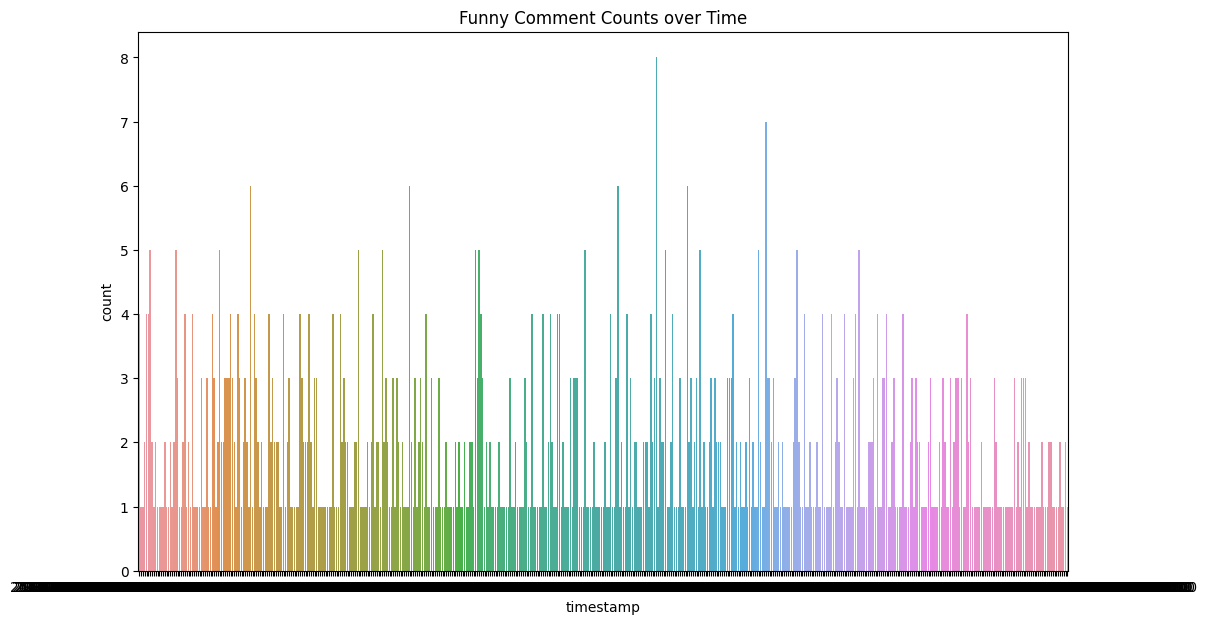

In [183]:
fig, axs = plt.subplots(figsize=(12,7))

sns.barplot(x='timestamp', y='count', data=time_series_df, ax=axs) \
    .set(title='Funny Comment Counts over Time')

Our data is a bit congested. Let's split up our data into quarters.

In [184]:
print('Datetime From:', min(x))
print('Dateime To:', max(x))

Datetime From: 2021-07-26T20:10:13.612000+00:00
Dateime To: 2022-11-10T02:36:11.685000+00:00


In [185]:
# These are strings for some reason. Had to convert to datetime.
time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp'], infer_datetime_format=True)

Before proceeding, let's convert `numpy.datetime64` to `datetime.date`.

In [186]:
def to_date(dt64):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((dt64 - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp).date()

In [187]:
time_series_df['timestamp'] = [to_date(dt64) for dt64 in time_series_df['timestamp'].values]

In [188]:
dfs = list()
quarters = [
    ('2021-07-01', '2021-09-30'),
    ('2021-10-01', '2021-12-31'),
    ('2022-01-01', '2022-03-31'),
    ('2022-04-01', '2022-06-30'),
    ('2022-07-01', '2022-09-30'),
    ('2022-10-01', '2022-12-31')
]

for start, end in quarters:
    mask = (time_series_df['timestamp'].values > np.datetime64(start)) & \
    (time_series_df['timestamp'].values < np.datetime64(end))
    
    dfs.append(time_series_df[mask].sort_values(by='timestamp'))

display(dfs[0])

,timestamp,emoji,count
252,2021-07-26,😂,1
251,2021-08-02,🤣,1
250,2021-08-13,🤣,1
249,2021-08-13,🤣,2
248,2021-08-13,🤣,1
247,2021-08-16,😂,1
246,2021-08-24,🤣,1
245,2021-08-31,🤣,1
244,2021-09-02,😂,5
243,2021-09-03,😂,1


Next we'll group by date.

In [189]:
grouped_dfs = list()
for df in dfs:
    grouped_df = df.groupby('timestamp').sum().reset_index()
    grouped_dfs.append(grouped_df)

display(grouped_dfs[0])

/tmp/ipykernel_11101/4151246452.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby('timestamp').sum().reset_index()
/tmp/ipykernel_11101/4151246452.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby('timestamp').sum().reset_index()
/tmp/ipykernel_11101/4151246452.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby('timestamp').sum().reset_index()
/

,timestamp,count
0,2021-07-26,1
1,2021-08-02,1
2,2021-08-13,4
3,2021-08-16,1
4,2021-08-24,1
5,2021-08-31,1
6,2021-09-02,5
7,2021-09-03,2
8,2021-09-08,1
9,2021-09-21,6


In [190]:
for df in grouped_dfs:
    days_until = list()
    
    # for each row except the first, determine the days since previous funny comment
    for ind, row in df.iterrows():
        if ind == df.shape[0]-1:
            days_until.append(None)
            break
        delta = df.iloc[ind+1, 0] - row['timestamp']
        days = delta.days

        days_until.append(days - 1)
    
    # this assignment is an overwrite, not a copy
    df['days_until_next'] = days_until

display(grouped_dfs[0])

,timestamp,count,days_until_next
0,2021-07-26,1,6.0
1,2021-08-02,1,10.0
2,2021-08-13,4,2.0
3,2021-08-16,1,7.0
4,2021-08-24,1,6.0
5,2021-08-31,1,1.0
6,2021-09-02,5,0.0
7,2021-09-03,2,4.0
8,2021-09-08,1,12.0
9,2021-09-21,6,1.0


Now we'll plot the days that passed before the next funny comment was posted for each day.

In [191]:
import math

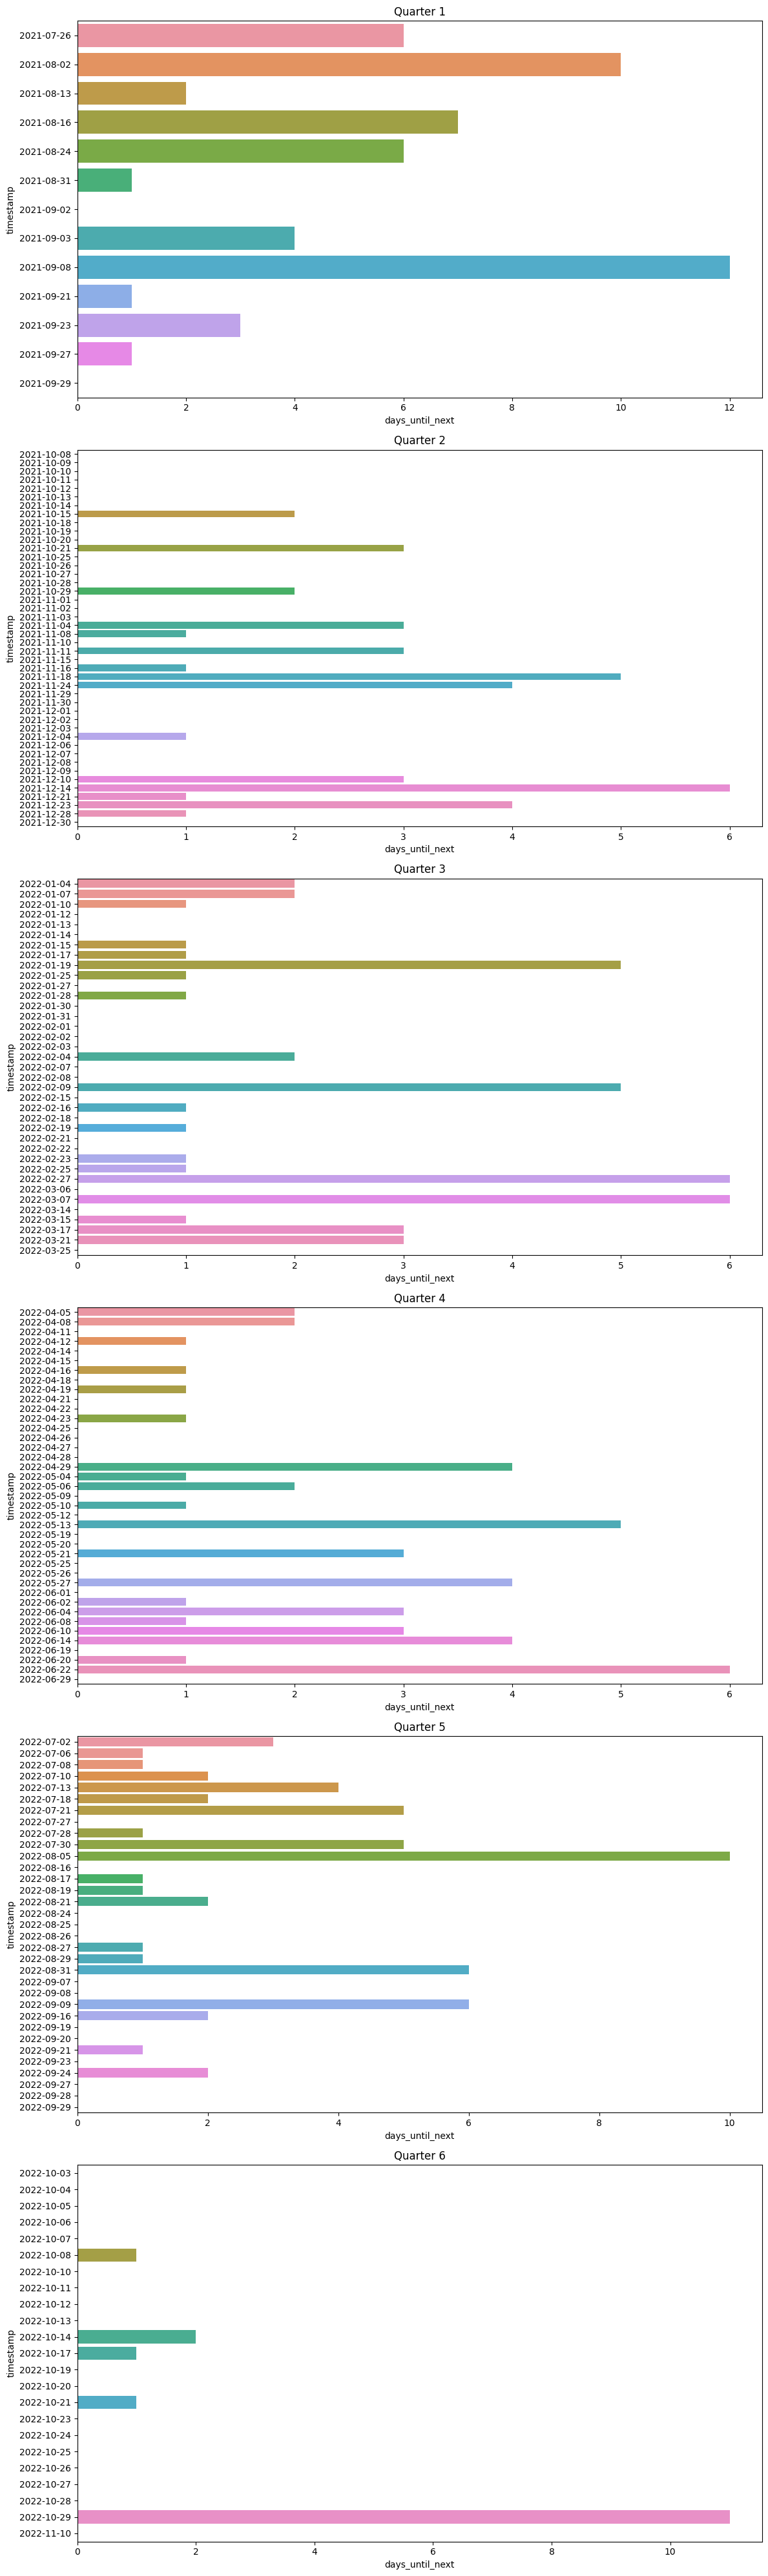

In [193]:
fig, axs = plt.subplots(6, figsize=(12,40))

for ind, df in enumerate(grouped_dfs):
    dates = df['timestamp'].values

    barplt = sns.barplot(x='days_until_next', y='timestamp', data=df, ax=axs[ind], orient='h') \
        .set(title=f'Quarter {ind + 1}')
    
    # quarters 1 and 6 have fewer days where data was collected
    if ind == 0 or ind == 5:
        total_days = 30
    else:
        total_days = 90
    

fig.tight_layout()

The plots are a bit hard to interpet but days of consecutive funny postings are the "empty" spaces in our plots, and the width of the bars represent the days elapsed until the next funny comment was posted.  

If funny comments happened in irregular "bursts" we would have seen many bars with varying bar widths, which upon visual inspection appears to be the case.

### A Side Note on Parsing JSON Data

I realized the day before my capstone due date that pandas has a `read_json` method. I wanted to see if it parses nested JSON or leaves them as a strings. I expected the latter, but was unfortunately proved wrong. Phooey.

In [ ]:
df = pd.read_json('~/brainstation/capstone/roffle/bds_data_list.json')
df

In [ ]:
df.info()

In [ ]:
# Pandas parses JSON!? They're not strings!?
id = [author['id'] for author in df['author']]
id

### For Funsies

Let's find the funniest users.

In [195]:
df = pd.read_csv('~/brainstation/capstone/roffle/eda/for_funsies.csv')
df

,username,emoji,count
0,pyrus277,😂,4
1,Ellie Shakeri,🤣,1
2,Kyle Jensen,😂,1
3,hiroshi,😂,2
4,Eko,😂,4
...,...,...,...
504,Punsmaster,😂,2
505,Punsmaster,🤣,1
506,Jack121,🤣,1
507,m57848,🤣,2


In [203]:
# group by user
ranked = df.groupby(['username']).sum().sort_values(by=['count'], ascending=False)
ranked

/tmp/ipykernel_11101/4200350962.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ranked = df.groupby(['username']).sum().sort_values(by=['count'], ascending=False)


,count
username,
Punsmaster,118
Frosted Flakes,95
Jack121,90
TheoreticalBartender,81
willoney,65
Orla,61
sehvye,61
Yatsor,60
pyrus277,44


Among Brainstation members Perry wins with 44 votes, I have 30.  

Ariyan, Ellie, Kyle, and Kylie are in the mix as well.

Let's see if I beat Perry if we take into account the emoji.

In [209]:
laugh_df = df[df['emoji'] == '😂'].groupby('username').sum().sort_values(by='count', ascending=False)
rofl_df = df[df['emoji'] == '🤣'].groupby('username').sum().sort_values(by='count', ascending=False)
display(laugh_df)

/tmp/ipykernel_11101/194750104.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  laugh_df = df[df['emoji'] == '😂'].groupby('username').sum().sort_values(by='count', ascending=False)
/tmp/ipykernel_11101/194750104.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rofl_df = df[df['emoji'] == '🤣'].groupby('username').sum().sort_values(by='count', ascending=False)


,count
username,
Punsmaster,43
Frosted Flakes,40
pyrus277,39
willoney,32
TheoreticalBartender,32
Jack121,30
Boozle,24
Yatsor,24
arita09,19


In [210]:
display(rofl_df)

,count
username,
Punsmaster,75
Jack121,60
Frosted Flakes,55
TheoreticalBartender,49
Orla,45
sehvye,43
Yatsor,36
willoney,33
Putrid,27


Most of Perry's counts come from 😂 reactions. But I killed in the 🤣 count.